# Discrete Convolution and Correlation

This notebook illustrates the (discrete) linear and circular convolutions.

* Graham, L., D. E. Knuth, and O. Patashnik (1994). Concrete mathematics: a foundation for computer science, 2 ed.: Addison-Wesley Publishing Company. ISBN 0-201-55802-5

* Yilmaz, Öz (2001). Seismic Data Analysis: Processing, Inversion, and Interpretation of Seismic Data, 2 ed.: Society of Exploration Geophysicists. ISBN 1-56080-098-4

* Oppenheim, A. V., and Schafer, R., W. (2010). Discrete-Time Signal Processing, 3 ed.: Pearson. ISBN 0-13-198842-5

* Uieda, L., V. C. Oliveira Jr, and V. C. F. Barbosa (2013), Modeling the Earth with Fatiando a Terra, Proceedings of the 12th Python in Science Conference, pp. 91 - 98. url: https://www.fatiando.org/v0.5/cite.html#cite

<a id='ref'></a>
## References

* Yilmaz, Öz (2001). Seismic Data Analysis: Processing, Inversion, and Interpretation of Seismic Data, 2 ed.: Society of Exploration Geophysicists. ISBN 1-56080-098-4

In [1]:
import numpy as np
from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from scipy.linalg import toeplitz, circulant, dft
import matplotlib.pyplot as plt
import my_functions as mfun

## Filtering in frequency domain by using a box filter

According to the notebook `convolution_correlation_1D_1`, the circular convolution in Fourier domain is given by:

$$
\mathbf{H} \, \mathbf{w} = \mathbf{f} \circ 
\left( \mathbf{H} \, \mathbf{a} \right) \: ,
$$

where 

$$
\mathbf{f} = \sqrt{N} \, \left( \mathbf{H} \, \mathbf{b} \right)
$$

and

$$
\mathbf{H} = \tfrac{1}{\sqrt{N}} \, \mathbf{F}_{N} \quad .
$$

Let's consider that $\mathbf{a}$ represents our signal, in time domain. In this case, the term $\mathbf{f}$ represents our filter and $\mathbf{H} \, \mathbf{w}$ represents the filtered signal, both in the Fourier domain.

<a id='sec1'></a>
## Synthetic data

In [2]:
# number of samples
N = 800

# period (in seconds)
T0 = 1

# sampling interval (is seconds)
dt = T0/N
print(dt)

# time (in seconds)
t = np.linspace(0, N*dt, N)

0.00125


In [3]:
def synthetic_signal(A, f, t):
    signal = np.zeros_like(t)
    for Ai, fi in zip(A, f):
        signal += Ai*np.sin(2*np.pi*fi*t)
    return signal

In [4]:
f_a = [ 2, 10, 30] # Hertz (Hz)
A_a = [15,  10, 5] # Amplitude

a = synthetic_signal(A_a, f_a, t)

a1 = synthetic_signal([A_a[0]], [f_a[0]], t)
a2 = synthetic_signal([A_a[1]], [f_a[1]], t)
a3 = synthetic_signal([A_a[2]], [f_a[2]], t)

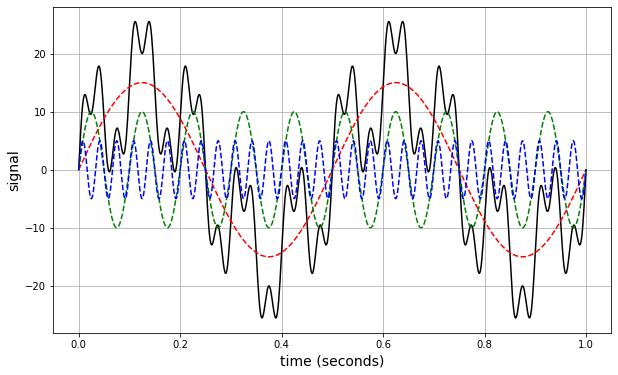

In [5]:
plt.figure(figsize=(10,6))
plt.plot(t, a, 'k-')
plt.plot(t, a1, 'r--')
plt.plot(t, a2, 'g--')
plt.plot(t, a3, 'b--')
plt.xlabel('time (seconds)', fontsize=14)
plt.ylabel('signal', fontsize=14)
plt.grid()
plt.show()

In [6]:
# Fourier transform of our signal
Ha = fft(x=a, norm='ortho')

In [7]:
# Amplitude of our signal
Amplitude_signal = np.abs(Ha)
Amp_max_signal = np.max(Amplitude_signal)

In [8]:
# Create the vector of frequencies
freqs = fftfreq(n=N, d=dt)

In [9]:
# Define our box filter to be applied in Fourier domain
def filter_box(freqs, cutoff):
    assert cutoff, 'cuttof is positive'
    f = np.ones_like(freqs)
    N = freqs.size
    mask_lower = (np.abs(freqs) < cutoff)
    mask_equal = (np.abs(freqs) == cutoff)
    mask_greater = (np.abs(freqs) > cutoff)
    f[mask_lower] = 1
    f[mask_equal] = 0.5
    f[mask_greater] = 0
    return f

In [10]:
# define the cutoff frequency
freq_cut = 15

In [11]:
np.min(freqs), np.max(freqs)

(-400.0, 399.0)

In [12]:
# Define the filter in frequency domain
f = filter_box(freqs=freqs, cutoff=freq_cut)

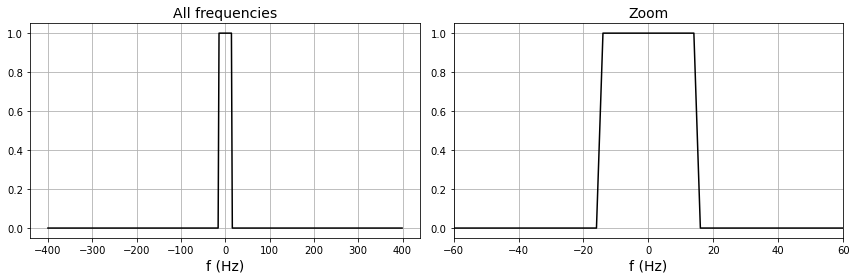

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('All frequencies', fontsize=14)
plt.plot(fftshift(freqs), fftshift(f), 'k-')
plt.xlabel('f (Hz)', fontsize=14)
plt.grid()

plt.subplot(1,2,2)
plt.title('Zoom', fontsize=14)
plt.plot(fftshift(freqs), fftshift(f), 'k-')
plt.xlabel('f (Hz)', fontsize=14)
plt.xlim(-60, 60)
plt.grid()

plt.tight_layout()

plt.show()

Our filter is an $N \times 1$ vector (where $N$ is the number of samples) formed by ones and zeros. The ones are placed at the positions with absolute frequencies smaller than `freq_cut`.

In [14]:
# Compute the circular convolution in Fourier domain, i.e.,
# compute the filtered signal in Fourier domain
Hw = f*Ha

In [15]:
Amplitude_w = np.abs(Hw)
Amp_max_w = np.max(Amplitude_w)

In [16]:
w = ifft(x=Hw, norm='ortho').real

In [17]:
# The filtered signal
Amplitude_filtered_freq = Amplitude_w
signal_filtered_freq = w

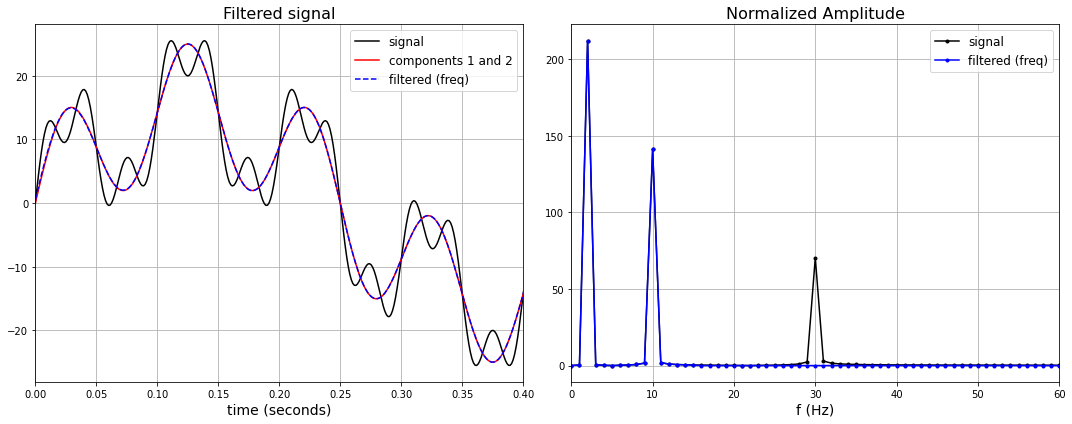

In [18]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.title('Filtered signal', fontsize=16)
plt.plot(t, a, 'k-', label='signal')
plt.plot(t, a1+a2, 'r-', label='components 1 and 2')
plt.plot(t, signal_filtered_freq, 'b--', label='filtered (freq)')
plt.xlabel('time (seconds)', fontsize=14)
plt.xlim(0, 0.4)
plt.grid()
plt.legend(loc='best', fontsize=12)

plt.subplot(1,2,2)
plt.title('Normalized Amplitude', fontsize=16)
plt.plot(freqs[:N//2], Amplitude_signal[:N//2], 'k.-', label='signal')
plt.plot(freqs[:N//2], Amplitude_filtered_freq[:N//2], 'b.-', label='filtered (freq)')
plt.xlim(0, 60)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.xlabel('f (Hz)', fontsize=14)

plt.tight_layout()

plt.show()

In the cells above, the operation of "removing parts of our signal" is represented by the Hadamard (entry-wise) product of our signal and our box filter (dashed red line), both in Fourier domain. The Amplitude spectra of the original (continuous black line) and filtered signals (continuous blue line) are shown in the right panel. Note that all values with absolute frequencies greater that `freq_cut` were removed (replaced by zero). The filtered signal (dashed blue line in the left panel) contains only components 1 (`f = 2` Hz and `A = 30`) and 1 (`f = 10` Hz and `A = 10`).

In [19]:
f_a

[2, 10, 30]

In [20]:
A_a

[15, 10, 5]

## Express the filtering process as a convolution in time domain

According to the notebook `convolution_correlation_1D_1`, the circular convolution in data (time) domain is given by:

$$
\mathbf{w} = \mathbf{C} \, \mathbf{a} \: ,
$$

where $\mathbf{C}$ is an $N \times N$ circulant matrix whose first column is formed by a vector $\mathbf{b}$. As we have previously defined, $\mathbf{a}$ represents our signal and $\mathbf{w}$ represents the filtered signal, both in time domain. In this case, $\mathbf{b} = \frac{1}{\sqrt{N}} \, \mathbf{H}^{\ast} \mathbf{f}$, where $\mathbf{f}$ is our filter in the Fourier domain.

In [21]:
# Compute b in time domain
b = ifft(x=f, norm='ortho')/np.sqrt(N)

In [22]:
# According to our definition, b is purely real, without imaginary component.
# However, due to numerical approximation, b usually has a very small imaginary component
# that can be neglected
print(b.imag[:20])

[-0.00000000e+00 -5.55111512e-19  2.01227923e-18 -1.59594560e-18
  1.83880688e-18 -6.24500451e-19  1.11022302e-18  3.40005801e-18
 -1.38777878e-19 -4.16333634e-19  5.55111512e-19  3.33066907e-18
  2.63677968e-18 -0.00000000e+00  1.38777878e-19  2.77555756e-19
  5.55111512e-19  1.38777878e-18 -2.08166817e-19  2.01227923e-18]


In [23]:
# Remove the small imaginary part
b = b.real

In [24]:
# Create the circulant matrix with b
C = circulant(b)

In [26]:
# Compute the filtered signal, in time domain, by using the matrix-vector approach
w = np.dot(C, a)

In [27]:
signal_filtered_time = w

In [28]:
FT_filtered_time = fft(x=signal_filtered_time, norm='ortho')

In [29]:
Amplitude_filtered_time = np.abs(FT_filtered_time)

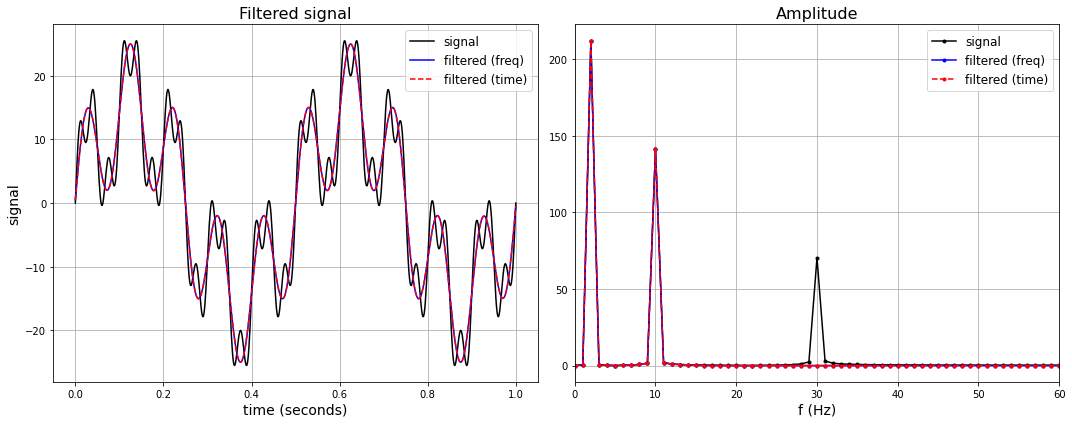

In [30]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.title('Filtered signal', fontsize=16)
plt.plot(t, a, 'k-', label='signal')
plt.plot(t, signal_filtered_freq, 'b-', label='filtered (freq)')
plt.plot(t, signal_filtered_time, 'r--', label='filtered (time)')
plt.xlabel('time (seconds)', fontsize=14)
plt.ylabel('signal', fontsize=14)
#plt.xlim(0, 0.4)
plt.grid()
plt.legend(loc='best', fontsize=12)

plt.subplot(1,2,2)
plt.title('Amplitude', fontsize=16)
plt.plot(freqs[:N//2], Amplitude_signal[:N//2], 'k.-', label='signal')
plt.plot(freqs[:N//2], Amplitude_filtered_freq[:N//2], 'b.-', label='filtered (freq)')
plt.plot(freqs[:N//2], Amplitude_filtered_time[:N//2], 'r.--', label='filtered (time)')
plt.xlim(0, 60)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.xlabel('f (Hz)', fontsize=14)

plt.tight_layout()

plt.show()

The main goal here is verify that the operation of "removing parts of our signal" (the filtering proccess) can be performed by following two different approaches: 

1. A Hadamard (entry-wise) product of our signal and our box filter (dashed red line), both in Fourier domain;

2. A matrix-vector product of a circulant matrix and our signal, both in time (data) domain.

Note that $\mathbf{b}$, defined in data domain, is proportional to the inverse Fourier transform of our filter $\mathbf{f}$, which is defined in frequency domain.

## What if our signal isn't sampled on a complete period?

In [ ]:
N_crop_atfer = 100
N_crop_before = 100
N_cropped = N - N_crop_before - N_crop_atfer

In [ ]:
signal_cropped = signal[N_crop_before:N-N_crop_atfer]
t_cropped = t[N_crop_before:N-N_crop_atfer]

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(t, signal, 'k-', linewidth=3, label='signal')
plt.plot(t_cropped, signal_cropped, 'r--', label='cropped')
plt.xlabel('time (seconds)', fontsize=14)
plt.ylabel('signal', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

In [ ]:
FT_signal_cropped = fft(x=signal_cropped, norm='ortho')

In [ ]:
Amplitude_signal_cropped = np.abs(FT_signal_cropped)
Amp_max_signal_cropped = np.max(Amplitude_signal_cropped)

In [ ]:
# create the vector of frequencies
freqs_cropped = fftfreq(n=N_cropped, d=dt)

In [ ]:
# define the cutoff frequency
freq_cut = 15

In [ ]:
# Define the filter in frequency domain
box_cropped = filter_box(freqs=freqs_cropped, cutoff=freq_cut)

In [ ]:
# Compute the circular convolution in frequency domain
FT_w_cropped = np.sqrt(N_cropped)*box_cropped*FT_signal_cropped

In [ ]:
Amplitude_w_cropped = np.abs(FT_w_cropped)
Amp_max_w_cropped = np.max(Amplitude_w_cropped)

In [ ]:
w_cropped = ifft(x=FT_w_cropped, norm='ortho').real

In [ ]:
# Divide the circular convolution by the scale factor to obtain the filtered signal
Amplitude_cropped_filtered_freq = Amplitude_w_cropped/np.sqrt(N_cropped)
signal_cropped_filtered_freq = w_cropped/np.sqrt(N_cropped)

In [ ]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.title('Filtered signal', fontsize=16)
plt.plot(t, signal, 'k-', linewidth=2, label='signal')
#plt.plot(t_cropped, signal_cropped, 'r--', label='cropped')
plt.plot(t, signal_filtered_freq, 'b--', label='filtered (freq)')
plt.plot(t_cropped, signal_cropped_filtered_freq, 'r--', label='filtered (freq) - crop')
plt.xlabel('time (seconds)', fontsize=14)
#plt.xlim(0, 0.4)
plt.grid()
plt.legend(loc='best', fontsize=12)

plt.subplot(1,2,2)
plt.title('Amplitude', fontsize=16)
plt.plot(freqs[:N//2], Amplitude_signal[:N//2], 'k.-', label='signal')
plt.plot(freqs[:N//2], Amplitude_filtered_freq[:N//2], 'b.-', label='filtered (freq)')
plt.plot(freqs_cropped[:N_cropped//2], Amplitude_cropped_filtered_freq[:N_cropped//2], 
         'r.-', label='filtered (freq) - crop')
plt.xlim(0, 60)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.xlabel('f (Hz)', fontsize=14)

plt.tight_layout()

plt.show()